# Local Reality and the CHSH inequality

We have seen in a previous module how quantum entanglement results in strong correlations in a multi-partite system. In fact these correlations appear to be stronger than anything that could be explained using classical physics. 

The historical development of quantum mechanics is filled with agitated discussions about the true nature of reality and the extent to which quantum mechanics can explain it. Given the spectacular empirical success of quantum mechanics, it was going to be clear that people would not simply give it up just because some of its aspects were hard to reconcile with intuition.

At the root of these different points of views was the question of the nature of measurement. We know there is an element of randomness in quantum measurements, but is that really so? Is there a sneaky way by which the Universe has already decided beforehand which value a given measurement is going to yield at a future time? This hypothesis was the basis for different _hidden variable_ theories. But these theories did not only need to explain randomness at the single particle level. They also needed to explain what happens when different observers measure different parts of a multi-partite entangled system! This went beyond just hidden variable theories. Now a local hidden variable theory was needed in order to reconcile the observations of quantum mechanics with a Universe in which local reality was valid.

What is local reality? In an Universe where locality holds, it should be possible to separate two systems so far in space that they could not interact with each other. The concept of reality is related to whether a measurable quantity holds a particular value _in the absence of any future measurement_. 

In 1963, John Stewart Bell published what could be argued as one of the most profound discoveries in the history of science. Bell stated that any theory invoking local hidden variables could be experimentally ruled out. In this section we are going to see how, and we will run a real experiment that demonstrates so! (with some remaining loopholes to close...)

### The CHSH inequality

Imagine Alice and Bob are given each one part of a bipartite entangled system. Each of them then performs two measurements on their part in two different bases. Let's call Alice's bases _A_ and _a_ and Bob's _B_ and _b_. What is the expectation value of the quantity $\langle CHSH \rangle = \langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle$ ? 

Now, Alice and Bob have one qubit each, so any measurement they perform on their system (qubit) can only yield one of two possible outcomes: +1 or -1. Note that whereas we typically refer to the two qubit states as $|0\rangle$ and $|1\rangle$, these are *eigenstates*, and a projective measurement will yield their *eigenvalues*, +1 and -1, respectively. 

Therefore, if any measurement of _A_, _a_, _B_, and _b_ can only yield $\pm 1$, the quantities $(B-b)$ and $(B+b)$ can only be 0 or $\pm2$. And thus, the quantity $A(B-b) + a(B+b)$ can only be either +2 or -2, which means that there should be a bound for the expectation value of the quantity we have called $|\langle CHSH \rangle| =|\langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle| \leq 2$.

Now, the above discussion is oversimplified, because we could consider that the outcome on any set of measurements from Alice and Bob could depend on a set of local hidden variables, but it can be shown with some math that, even when that is the case, the expectation value of the quantity $CHSH$ should be bounded by 2 if local realism held.

But what happens when we do these experiments with an entangled system? Let's try it!

In [1]:
#import qiskit tools
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, transpile, Aer, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise

#import python stuff
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
# Set devices, if using a real device
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
lima = provider.get_backend('ibmq_lima')

In [2]:
sv_sim = Aer.get_backend('statevector_simulator')
qasm_sim = Aer.get_backend('qasm_simulator')

First we are going to define a function to create our CHSH circuits. We are going to choose, without loss of generality, that Bob always uses the computational ($Z$) and the $X$ bases for his $B$ and $b$ measurements, respectively, whereas Alice chooses also orthogonal bases but whose angle we are going to vary between $0$ and $2\pi$ with respect to Bob's bases. This set of angles is going to be the input argument to our $CHSH$ circuit building function.

In [3]:
def make_chsh_circuit(theta_vec):
    """Return a list of QuantumCircuits for use in a CHSH experiemnt
    (one for each value of theta in theta_vec)
    
        Args:
            theta_vec (list): list of values of angles between the bases of Alice and Bob
        
        Returns:
            List[QuantumCircuit]: CHSH QuantumCircuits for each value of theta
    """
    chsh_circuits = []
    
    for theta in theta_vec:
        obs_vec = ['00', '01', '10', '11']
        for el in obs_vec:
            qc = QuantumCircuit(2,2)
            qc.h(0)
            qc.cx(0, 1)
            qc.ry(theta, 0)
            for a in range(2):
                if el[a] == '1':
                    qc.h(a) 
            qc.measure(range(2),range(2))
            chsh_circuits.append(qc)

    return chsh_circuits  

Next, we are going to define a function for estimating the quantity $\langle CHSH \rangle$. One can define two of such quantities, actually, $\langle CHSH1 \rangle = \langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle$ and $\langle CHSH2 \rangle = \langle AB \rangle + \langle Ab \rangle - \langle aB \rangle + \langle ab \rangle$. Once chosen the corresponding measurement axes for both parties, each expectation value can be simply estimated by adding the counts from the output bitstrings with the appropiate sign (plus for the even terms $00$ and $11$ and minus for odd terms $01$ and $10$.

In [4]:
def compute_chsh_witness(counts):
    """Computes expectation values for the CHSH inequality, for each
    angle (theta) between measurement axis.

        Args: counts (list[dict]): dict of counts for each experiment
              (4 per value of theta)

        Returns:
            Tuple(List, List): Tuple of lists with the two CHSH witnesses
    """
    # Order is ZZ,ZX,XZ,XX
    
    CHSH1 = []
    CHSH2 = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):  
        theta_dict = counts[i:i + 4]
        zz = theta_dict[0]
        zx = theta_dict[1]
        xz = theta_dict[2]
        xx = theta_dict[3]

        no_shots = sum(xx[y] for y in xx)

        chsh1 = 0
        chsh2 = 0

        for element in zz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zz[element]
            chsh2+= parity*zz[element]

        for element in zx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zx[element]
            chsh2-= parity*zx[element]

        for element in xz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1-= parity*xz[element]
            chsh2+= parity*xz[element]

        for element in xx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*xx[element]
            chsh2+= parity*xx[element]

        CHSH1.append(chsh1/no_shots)
        CHSH2.append(chsh2/no_shots)
    
    return CHSH1, CHSH2

Finally, we are going to split the interval $[0, 2\pi)$ into 15 angles and will build the corresponding set of $CHSH$ circuits

In [5]:
number_of_thetas = 15
theta_vec = np.linspace(0,2*np.pi,number_of_thetas)
my_chsh_circuits = make_chsh_circuit(theta_vec)

Now, let's have a brief look at how four of these circuits look like for a given $\theta$

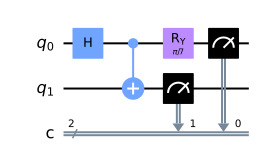

In [7]:
my_chsh_circuits[4].draw('mpl')

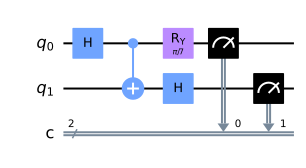

In [8]:
my_chsh_circuits[5].draw('mpl')

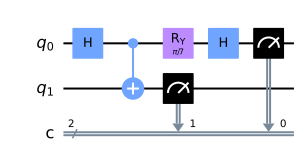

In [9]:
my_chsh_circuits[6].draw('mpl')

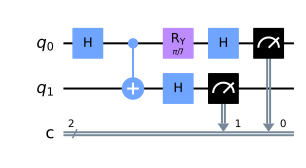

In [10]:
my_chsh_circuits[7].draw('mpl')

These circuits are simply creating a Bell pair, and then measuring each party in a different basis. While Bob ($q_1$) always measures either in the computational basis or the $X$ basis, Alice's measurement basis rotates by the angle $\theta$ with respect to Bob's.

In [7]:
# Execute and get counts
result_ideal = execute(my_chsh_circuits, qasm_sim).result()

tic = time.time()
job_real = execute(my_chsh_circuits, backend=lima, shots=8192)
job_monitor(job_real)
result_real = job_real.result()
toc = time.time()

print(toc-tic)

Job Status: job has successfully run
7.394834041595459


In [8]:
CHSH1_ideal, CHSH2_ideal = compute_chsh_witness(result_ideal.get_counts())
CHSH1_real, CHSH2_real = compute_chsh_witness(result_real.get_counts())

Now we plot the results

Text(0, 0.5, 'CHSH witness')

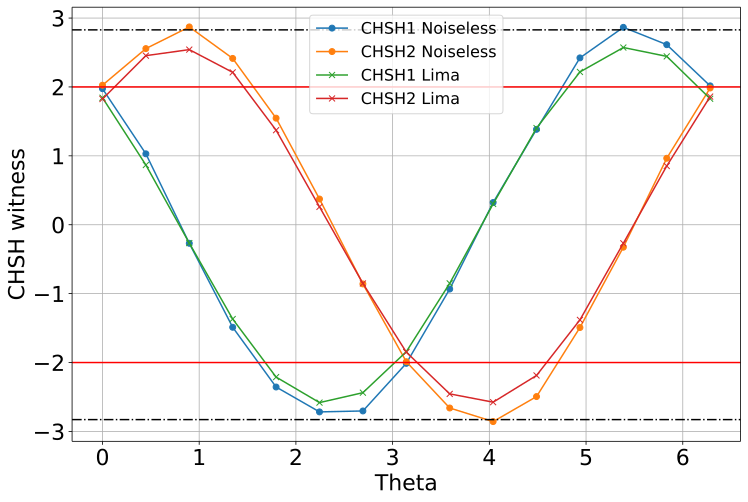

In [9]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
plt.plot(theta_vec,CHSH1_ideal,'o-',label = 'CHSH1 Noiseless')
plt.plot(theta_vec,CHSH2_ideal,'o-',label = 'CHSH2 Noiseless')

plt.plot(theta_vec,CHSH1_real,'x-',label = 'CHSH1 Lima')
plt.plot(theta_vec,CHSH2_real,'x-',label = 'CHSH2 Lima')

plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')

Note what happened! There are some particular combination of measurement bases for which $|CHSH| \geq 2$. How is this possible? Let's look at our entangled bipartite system. It is easy to show that if $|\psi \rangle = 1/\sqrt{2} (|00\rangle + |11\rangle)$, then the expectation value $\langle AB \rangle = \langle \psi|A \otimes B| \psi \rangle = -\cos \theta_{AB}$ where $\theta_{AB}$ is the angle between the measurement bases $A$ and $B$. Therefore, for the particular choise of bases $A = 1/\sqrt{2}(\sigma_z - \sigma_x)$ and $a = 1/\sqrt{2}(\sigma_z + \sigma_x)$, letting Bob measure with $B=\sigma_z$ and $b=\sigma_x$, we see that $|\langle CHSH1 \rangle| = 2\sqrt{2} > 2$. It can also be shown that $2\sqrt{2}$ is the maximum possible value attainable, even in the quantum case (dash-dotted line in the plot).

The above inequality is called CHSH after Clauser, Horne, Shimony, and Holt, and it is the most popular way of presenting the original inequality from Bell.

The fact that we violated the CHSH inequality in our real device is of significance. Just a decade ago such an experiment would have been of great impact. Nowadays, quantum devices have become significantly better and these results can be replicated easily in state-of-the-art hardware. However, there are a number of loopholes that have to be closed when violating the inequality in order to claim that either locality or realism have been disproven. These are the detection loophole (where our detector is faulty and fails to provide meaningful statistics) and the locality/causality loophole (where the two parts of the entangled system are separated by a distance smaller than the distance covered by the light in the time it takes to perform a measurement). Given we can generate entangled pairs with high fidelity and every measurement yields a result (this is, no measured particle is "lost"), we have closed the detection loophole in our experiments above. However, given the distance between our qubits (a few mm) and the time it takes to perform a measurement (order of $\mu$s), we cannot claim we closed the causality loophole.

### Exercise

Consider a game where Alice and Bob are put in separate rooms and each is given a bit $x$ and $y$, respectively. These bits are chosen at random and idependently of each other. On receiving the bit each of them replies with a bit of their own, $a$ and $b$. Now, Alice and Bob win the game if $a$ and $b$ are different whenever $x=y=1$ and equal otherwise. It is easy to see that the best possible strategy for Alice and Bob is to always give $a=b=0$ (or $1$). With this strategy, Alice and Bob can win the game at most 75% of the time. 

Imagine Alice and Bob are allowed to share an entangled two-qubit state. Is there a strategy they can use that would give them a better chance of winning than 75%? (Remember that they can agree upon any strategy beforehand, but once they are given the random bits they cannot communicate anymore. They can take their respective parts of the entangled pair with them at all times, of course.)